# Model development

In [1]:
import os
import sys

import numpy as np
import seaborn as sns
import shap
import joblib
from scipy.stats import randint, uniform

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from xgboost import XGBClassifier


/home/rluyck/git/gps-stop-detection/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Add absolute path to the src directory
src_path = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
if src_path not in sys.path:
    sys.path.append(src_path)
    
from preprocessor import read_and_preprocess
from feature_engineering import add_features 
from stop_detector_rb import rule_based_detection
from model_utils import get_feature_columns

In [3]:
# Read and preprocess data
with open("../data/raw/gps_traces.csv", "rb") as f:
    preprocessed_gdf = read_and_preprocess(f.read())

preprocessed_gdf.head()

,trace_number,device_id,geometry,timestamp
0,2,0,POINT (116.59096 40.07196),2009-06-29 07:02:25+00:00
1,2,0,POINT (116.5909 40.07201),2009-06-29 07:02:30+00:00
2,2,0,POINT (116.59088 40.07203),2009-06-29 07:02:35+00:00
3,2,0,POINT (116.59092 40.072),2009-06-29 07:02:40+00:00
4,2,0,POINT (116.59096 40.07198),2009-06-29 07:02:45+00:00


In [4]:
enriched_gdf = add_features(preprocessed_gdf)
enriched_gdf.head()

/home/rluyck/git/gps-stop-detection/src/feature_engineering.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_features_for_trace)


,trace_number,device_id,geometry,timestamp,lat,lon,distance_m,time_diff_s,speed_kmh
0,2,0,POINT (116.59096 40.07196),2009-06-29 07:02:25+00:00,40.071961,116.590957,0.000000,0.0,0.000000
1,2,0,POINT (116.5909 40.07201),2009-06-29 07:02:30+00:00,40.072007,116.590905,6.764954,5.0,4.870767
2,2,0,POINT (116.59088 40.07203),2009-06-29 07:02:35+00:00,40.072027,116.590879,3.138583,5.0,2.259780
3,2,0,POINT (116.59092 40.072),2009-06-29 07:02:40+00:00,40.072004,116.590915,3.994090,5.0,2.875745
4,2,0,POINT (116.59096 40.07198),2009-06-29 07:02:45+00:00,40.071983,116.590961,4.564513,5.0,3.286449


In [5]:
# Label stops with rule-based logic
labeled_df = rule_based_detection(enriched_gdf)
labeled_df.head()

,trace_number,device_id,geometry,timestamp,lat,lon,distance_m,time_diff_s,speed_kmh,stopped
1,2,0,POINT (116.5909 40.07201),2009-06-29 07:02:30+00:00,40.072007,116.590905,6.764954,5.0,4.870767,False
2,2,0,POINT (116.59088 40.07203),2009-06-29 07:02:35+00:00,40.072027,116.590879,3.138583,5.0,2.259780,False
3,2,0,POINT (116.59092 40.072),2009-06-29 07:02:40+00:00,40.072004,116.590915,3.994090,5.0,2.875745,False
4,2,0,POINT (116.59096 40.07198),2009-06-29 07:02:45+00:00,40.071983,116.590961,4.564513,5.0,3.286449,False
5,2,0,POINT (116.59101 40.07196),2009-06-29 07:02:50+00:00,40.071960,116.591012,5.044699,5.0,3.632183,False


### Remove outliers

In [6]:
labeled_df.shape

(5808, 10)

In [7]:
labeled_df["speed_kmh"].describe()

count    5808.000000
mean       18.939399
std        20.111055
min         0.000000
25%         5.371228
50%        12.941570
75%        27.679209
max       392.962870
Name: speed_kmh, dtype: float64

<Axes: title={'center': 'Speed Distribution (km/h)'}, ylabel='Frequency'>

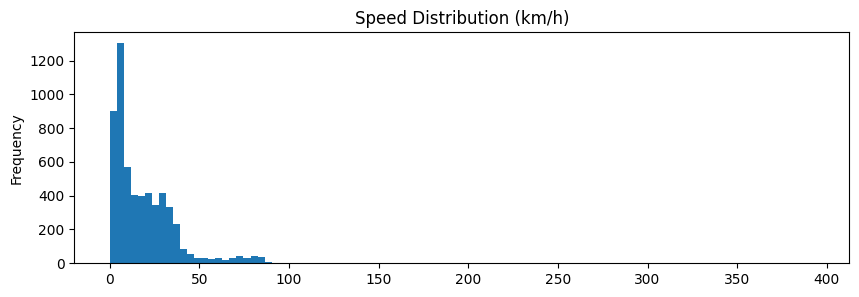

In [8]:
labeled_df["speed_kmh"].plot(kind="hist", bins=100, figsize=(10, 3), title="Speed Distribution (km/h)")

In [9]:
labeled_df = labeled_df[labeled_df['speed_kmh'] < 150]  # Filter out unrealistic speeds

<Axes: title={'center': 'Speed Distribution (km/h)'}, ylabel='Frequency'>

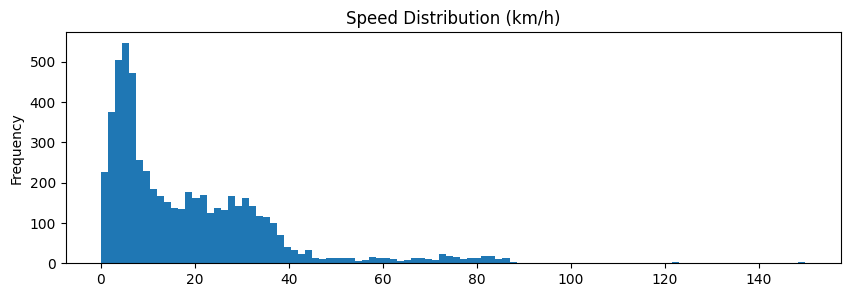

In [10]:
labeled_df["speed_kmh"].plot(kind="hist", bins=100, figsize=(10, 3), title="Speed Distribution (km/h)")

In [11]:
labeled_df["time_diff_s"].describe()

count     5798.000000
mean        10.926354
std        313.543543
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max      19698.000000
Name: time_diff_s, dtype: float64

<Axes: title={'center': 'time_diff (seconds) Distribution'}, ylabel='Frequency'>

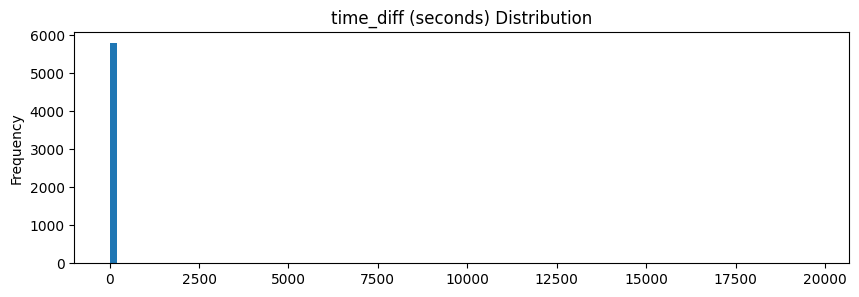

In [12]:
labeled_df["time_diff_s"].plot(kind="hist", bins=100, figsize=(10, 3), title="time_diff (seconds) Distribution")

In [13]:
labeled_df = labeled_df[labeled_df['time_diff_s'] < 10]  # Filter out unrealistic time differences

<Axes: title={'center': 'time_diff (seconds) Distribution'}, ylabel='Frequency'>

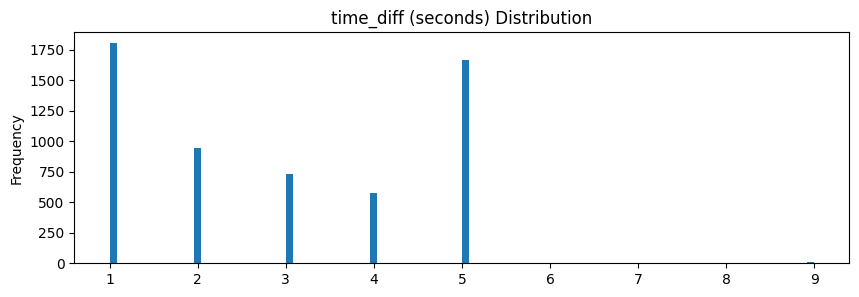

In [14]:
labeled_df["time_diff_s"].plot(kind="hist", bins=100, figsize=(10, 3), title="time_diff (seconds) Distribution")

In [15]:
labeled_df.shape

(5740, 10)

In [16]:
labeled_df.stopped.value_counts()

stopped
False    5629
True      111
Name: count, dtype: int64

### Avoiding data leakage

- We want to keep all GPS points from the same trace together (not part in train, part in test).
- This gives us trace-level generalization and avoids "cheating" by seeing parts of the same trace in both training and evaluation.

In [17]:
unique_traces = labeled_df[['device_id', 'trace_number']].drop_duplicates().reset_index(drop=True)
unique_traces

,device_id,trace_number
0,0,2
1,2,3
2,2,4
3,2,5
4,19,1


### Train (60%), Validation (20%), Test (20%)

1. Split dataset → train / validation / test
2. Train model on training set
3. Tune model using validation set
4. Evaluate it once on the test set

In [18]:
trainval_traces, test_traces = train_test_split(unique_traces, test_size=0.2, random_state=42) # Split 80% for training/validation and 20% for testing
trainval_traces = trainval_traces.reset_index(drop=True)
test_traces = test_traces.reset_index(drop=True)

train_traces, val_traces = train_test_split(trainval_traces, test_size=0.25, random_state=42) # Split 60% for training and 20% for validation
train_traces = train_traces.reset_index(drop=True)
val_traces = val_traces.reset_index(drop=True)


In [19]:
trainval_traces

,device_id,trace_number
0,19,1
1,2,4
2,0,2
3,2,5


In [20]:
train_df = labeled_df.merge(train_traces, on=['device_id', 'trace_number'])  # inner join by default
val_df   = labeled_df.merge(val_traces, on=['device_id', 'trace_number'])
test_df  = labeled_df.merge(test_traces, on=['device_id', 'trace_number'])

In [21]:
train_df.head()

,trace_number,device_id,geometry,timestamp,lat,lon,distance_m,time_diff_s,speed_kmh,stopped
0,2,0,POINT (116.5909 40.07201),2009-06-29 07:02:30+00:00,40.072007,116.590905,6.764954,5.0,4.870767,False
1,2,0,POINT (116.59088 40.07203),2009-06-29 07:02:35+00:00,40.072027,116.590879,3.138583,5.0,2.259780,False
2,2,0,POINT (116.59092 40.072),2009-06-29 07:02:40+00:00,40.072004,116.590915,3.994090,5.0,2.875745,False
3,2,0,POINT (116.59096 40.07198),2009-06-29 07:02:45+00:00,40.071983,116.590961,4.564513,5.0,3.286449,False
4,2,0,POINT (116.59101 40.07196),2009-06-29 07:02:50+00:00,40.071960,116.591012,5.044699,5.0,3.632183,False


In [22]:
feature_cols = get_feature_columns(labeled_df)
feature_cols

X_train = train_df[feature_cols]
y_train = train_df['stopped']

X_val = val_df[feature_cols]
y_val = val_df['stopped']

X_test = test_df[feature_cols]
y_test = test_df['stopped']

In [23]:
X_train.head()

,distance_m,lat,lon
0,6.764954,40.072007,116.590905
1,3.138583,40.072027,116.590879
2,3.994090,40.072004,116.590915
3,4.564513,40.071983,116.590961
4,5.044699,40.071960,116.591012


### Baseline - logistic regression

In [24]:
logreg_clf = make_pipeline(
    StandardScaler(),  # important for logistic regression because sensitive to feature scales 
    LogisticRegression(class_weight='balanced',  # handle class imbalance
                       random_state=42,
                       max_iter=1000)  # this will ensure convergence
)

In [25]:
y_train.value_counts(normalize=True)

stopped
False    0.966729
True     0.033271
Name: proportion, dtype: float64

A high class imbalance

In [26]:
logreg_clf.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [27]:

print("Validation performance:\n")
print(classification_report(y_val, logreg_clf.predict(X_val), zero_division=0))

print("Test performance:\n")
print(classification_report(y_test, logreg_clf.predict(X_test), zero_division=0))


Validation performance:

              precision    recall  f1-score   support

       False       1.00      0.96      0.98      1804
        True       0.20      1.00      0.33        17

    accuracy                           0.96      1821
   macro avg       0.60      0.98      0.65      1821
weighted avg       0.99      0.96      0.97      1821

Test performance:

              precision    recall  f1-score   support

       False       1.00      0.97      0.99      1762
        True       0.33      1.00      0.50        23

    accuracy                           0.97      1785
   macro avg       0.67      0.99      0.74      1785
weighted avg       0.99      0.97      0.98      1785



- De True class (stops) is very rare.
- Logistic regression is a linear model and cannot capture subtle, non-linear boundaries well.

### Random Forest Classifier

- The RandomForestClassifier works by training many decision trees on random subsets of the data and features.
- Each tree votes on the class, and the majority vote decides the final prediction.
- This reduces overfitting and improves generalization compared to a single decision tree.

In [ ]:
best_score = 0
best_params = None
best_model = None

# Manual randomized search
np.random.seed(42)
for i in range(100):  # n_iter=100
    # Sample random parameters
    params = {
        'n_estimators': np.random.randint(100, 400),
        'max_depth': np.random.randint(5, 20),
        'min_samples_split': np.random.randint(2, 10),
        'min_samples_leaf': np.random.randint(1, 4),
        'max_features': np.random.choice(['sqrt', 'log2']),
        'class_weight': 'balanced'
    }
    
    # Train model with these parameters
    model = RandomForestClassifier(random_state=42, **params)
    model.fit(X_train, y_train)
    
    # Evaluate on validation set - F1 for True class only
    val_pred = model.predict(X_val)
    val_score = f1_score(y_val, val_pred, pos_label=True)  # F1 for True class only
    
    if val_score > best_score:
        best_score = val_score
        best_params = params
        best_model = model
    
    if i % 10 == 0:
        print(f"Iteration {i}: Best validation F1 (True class) = {best_score:.4f}")

print(f"Best parameters: {best_params}")
print(f"Best validation F1 (True class): {best_score:.4f}\n")

# Final evaluation on test set - also show True class F1
test_pred = best_model.predict(X_test)
test_score_true = f1_score(y_test, test_pred, pos_label=True)  # True class F1
test_score_weighted = f1_score(y_test, test_pred, average='weighted')  # Overall F1

print(f"Test F1 (True class): {test_score_true:.4f}")
print(f"Test F1 (weighted): {test_score_weighted:.4f}")

Iteration 0: Best validation F1 (True class) = 0.6800
Iteration 10: Best validation F1 (True class) = 0.6800
Iteration 20: Best validation F1 (True class) = 0.6800
Iteration 30: Best validation F1 (True class) = 0.6800
Iteration 40: Best validation F1 (True class) = 0.6800
Iteration 50: Best validation F1 (True class) = 0.6800
Iteration 60: Best validation F1 (True class) = 0.6800
Iteration 70: Best validation F1 (True class) = 0.6800
Iteration 80: Best validation F1 (True class) = 0.6800
Iteration 90: Best validation F1 (True class) = 0.6800
Best parameters: {'n_estimators': 202, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': np.str_('sqrt'), 'class_weight': 'balanced'}
Best validation F1 (True class): 0.6800

Test F1 (True class): 0.8364
Test F1 (weighted): 0.9954


In [29]:
# Evaluate on validation set
print("Validation performance:")
print(classification_report(y_val, best_model.predict(X_val)))

Validation performance:
              precision    recall  f1-score   support

       False       1.00      0.99      1.00      1804
        True       0.52      1.00      0.68        17

    accuracy                           0.99      1821
   macro avg       0.76      1.00      0.84      1821
weighted avg       1.00      0.99      0.99      1821



In [30]:
# Evaluate on test set
print("Test performance:")
print(classification_report(y_test, best_model.predict(X_test)))

Test performance:
              precision    recall  f1-score   support

       False       1.00      0.99      1.00      1762
        True       0.72      1.00      0.84        23

    accuracy                           0.99      1785
   macro avg       0.86      1.00      0.92      1785
weighted avg       1.00      0.99      1.00      1785



In [31]:
# Save model
model_path = "../models/stop_model_rfc.pkl"
joblib.dump(best_model, model_path)

['../models/stop_model_rfc.pkl']

## SHAP values

How SHAP works

- SHAP is based on both the model and the data
- It uses the trained model to see how predictions change when features are included or left out.
- It uses the data to simulate realistic feature combinations.
- In short: SHAP explains how each feature contributes to a prediction, given the model and the data distribution.

### Why we use the validation set (X_val) for SHAP
- We don't use the training set → the model has already seen it; SHAP would reflect memorization.
- We avoid the test set → we keep it untouched for final evaluation.
- The validation set is ideal: it's unseen during training, but okay to use during model development for interpretation like SHAP.

/tmp/ipykernel_23412/2808451020.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_class, X_val)


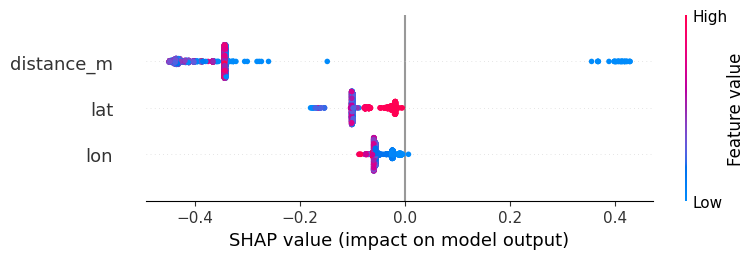

In [32]:
# Create a SHAP explainer for a tree-based model (e.g. Random Forest, XGBoost)
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values for the validation set
shap_values = explainer.shap_values(X_val)

if isinstance(shap_values, list):
    # Older versions of SHAP return a list of arrays (one per class)
    shap_values_class = shap_values[1]
else:
    # Newer SHAP versions return a 3D array: (n_samples, n_features, n_classes)
    shap_values_class = shap_values[:, :, 1]

# Plot a summary of SHAP values to show feature importance and direction
shap.summary_plot(shap_values_class, X_val)


### XGBOOST

In [33]:
best_score = 0
best_params = None
best_model = None

# Manual randomized search
np.random.seed(42)
for i in range(100):  # n_iter=100
    # Sample random parameters
    params = {
        'n_estimators': np.random.randint(100, 400),
        'max_depth': np.random.randint(5, 20),
        'learning_rate': np.random.uniform(0.01, 0.31),  # 0.01 to 0.31 (0.01 + 0.3)
        'subsample': np.random.uniform(0.6, 1.0),        # 0.6 to 1.0 (0.6 + 0.4)
        'colsample_bytree': np.random.uniform(0.6, 1.0), # 0.6 to 1.0 (0.6 + 0.4)
        'scale_pos_weight': np.random.choice([1, 2, 5]),
        'gamma': np.random.uniform(0, 5),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'random_state': 42
    }
    
    # Train model with these parameters
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    
    # Evaluate on validation set - F1 for True class only
    val_pred = model.predict(X_val)
    val_score = f1_score(y_val, val_pred, pos_label=True)  # F1 for True class only
    
    if val_score > best_score:
        best_score = val_score
        best_params = params
        best_model = model
    
    if i % 10 == 0:
        print(f"Iteration {i}: Best validation F1 (True class) = {best_score:.4f}")

print(f"Best parameters: {best_params}")
print(f"Best validation F1 (True class): {best_score:.4f}\n")

# Final evaluation on test set - also show True class F1
test_pred = best_model.predict(X_test)
test_score_true = f1_score(y_test, test_pred, pos_label=True)  # True class F1
test_score_weighted = f1_score(y_test, test_pred, average='weighted')  # Overall F1

print(f"Test F1 (True class): {test_score_true:.4f}")
print(f"Test F1 (weighted): {test_score_weighted:.4f}")

Iteration 0: Best validation F1 (True class) = 0.6800
Iteration 10: Best validation F1 (True class) = 0.8333
Iteration 20: Best validation F1 (True class) = 0.8333
Iteration 30: Best validation F1 (True class) = 0.8333
Iteration 40: Best validation F1 (True class) = 0.8333
Iteration 50: Best validation F1 (True class) = 0.8333
Iteration 60: Best validation F1 (True class) = 0.8333
Iteration 70: Best validation F1 (True class) = 0.8333
Iteration 80: Best validation F1 (True class) = 0.8333
Iteration 90: Best validation F1 (True class) = 0.8333
Best parameters: {'n_estimators': 153, 'max_depth': 14, 'learning_rate': 0.18031009834599745, 'subsample': 0.6125253169822235, 'colsample_bytree': 0.9369139098379994, 'scale_pos_weight': np.int64(2), 'gamma': 1.9757511800090721, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'random_state': 42}
Best validation F1 (True class): 0.8333

Test F1 (True class): 0.7500
Test F1 (weighted): 0.9940


In [34]:
# Evaluate on validation set
print("Validation performance:")
print(classification_report(y_val, best_model.predict(X_val)))

# Evaluate on test set
print("Test performance:")
print(classification_report(y_test, best_model.predict(X_test)))

Validation performance:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1804
        True       0.79      0.88      0.83        17

    accuracy                           1.00      1821
   macro avg       0.89      0.94      0.92      1821
weighted avg       1.00      1.00      1.00      1821

Test performance:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1762
        True       0.88      0.65      0.75        23

    accuracy                           0.99      1785
   macro avg       0.94      0.83      0.87      1785
weighted avg       0.99      0.99      0.99      1785



In [35]:
# Save model
model_path = "../models/stop_model_xgb.pkl"
joblib.dump(best_model, model_path)

['../models/stop_model_xgb.pkl']

/tmp/ipykernel_23412/300561037.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val)


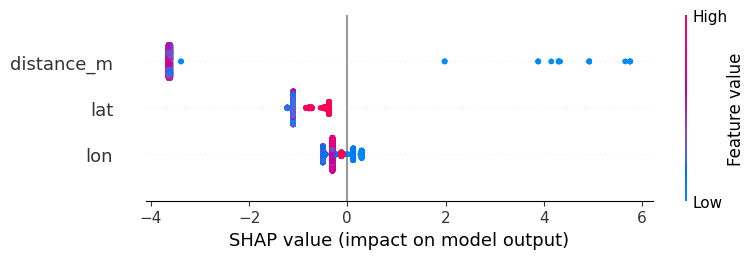

In [36]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val)
